# Определение перспективного тарифа для телеком-компании

## Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


**Описание тарифов**

**Тариф «Смарт»**
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.  

**Тариф «Ультра»**
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.


**Описание данных**  

**Таблица users** (информация о пользователях):  
•	user_id — уникальный идентификатор пользователя  
•	first_name — имя пользователя  
•	last_name — фамилия пользователя  
•	age — возраст пользователя (годы)  
•	reg_date — дата подключения тарифа (день, месяц, год)  
•	churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
•	city — город проживания пользователя  
•	tarif — название тарифного плана  

**Таблица calls** (информация о звонках):    
•	id — уникальный номер звонка  
•	call_date — дата звонка  
•	duration — длительность звонка в минутах  
•	user_id — идентификатор пользователя, сделавшего звонок  

**Таблица messages** (информация о сообщениях):      
•	id — уникальный номер звонка  
•	message_date — дата сообщения  
•	user_id — идентификатор пользователя, отправившего сообщение  

**Таблица internet** (информация об интернет-сессиях):      
•	id — уникальный номер сессии  
•	mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
•	session_date — дата интернет-сессии  
•	user_id — идентификатор пользователя  

**Таблица tariffs** (информация о тарифах):      
•	tariff_name — название тарифа  
•	rub_monthly_fee — ежемесячная абонентская плата в рублях  
•	minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
•	messages_included — количество сообщений в месяц, включённых в абонентскую плату  
•	mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
•	rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
•	rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
•	rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  



## Загрузка данных и изучение общей информации

**Путь к файлам:**  

•	/datasets/calls.csv  
•	/datasets/internet.csv  
•	/datasets/messages.csv  
•	/datasets/tariffs.csv  
•	/datasets/users.csv  

In [1]:
#подключение библиотек, используемых в проекте
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats as st
import math as mt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('chained_assignment', None) 

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [3]:
#определим свпомогательную функцию
def df_info(df):
    df.info()
    display(df.head())
    print('Дубликатов в исходных данных: ',df.duplicated().sum())

In [4]:
df_info(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Дубликатов в исходных данных:  0


In [5]:
df_info(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Дубликатов в исходных данных:  0


In [6]:
df_info(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Дубликатов в исходных данных:  0


In [7]:
df_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Дубликатов в исходных данных:  0


In [8]:
df_info(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Дубликатов в исходных данных:  0


### Выводы

Данные загружены в датафреймы:  
- users  
- calls  
- messages  
- internet  
- tariffs  

Дубликаты в исходных данных отсутствуют.  
При первичном изучении данных выявлено:
  
**users**
- есть пропуски в столбце churn_date, но они указывают на то, что пользователь еще пользуется тарифом, поэтому действий по обработке не требуют  
- столбцы churn_date и reg_date необходимо привести к типу datetime

**calls**  
- пропусков в данных нет  
- есть звонки в нулевой продолжительностью, но по исходному описанию проекта мы знаем что нулями обозначены пропущенные звонки, поэтому удалять их не нужно  
- продолжительность звонков округлим в большую сторону до минут по условиям тарификации. После округления преобразуем данные к типу int64  
- колонка id нам в дальнейшем не понадобится, поэтому можно ее удалить  

**messages**  
- пропусков в данных нет  
- столбец session_date необходимо привести к типу datetime  
- колонка id нам в дальнейшем не понадобится, поэтому можно ее удалить  

**internet**  
- пропусков в данных нет  
- столбец session_date необходимо привести к типу datetime  
- колонка id и Unnamed:0 нам в дальнейшем не понадобятся, поэтому можно их удалить  

**tariffs**  
- пропусков в данных нет  
- переименуем колонку tariff_name в tariff для удобства дальнейшего объединения таблиц функцией merge

## Подготовка данных

Проведем подготовку данных в соответствии с выводами предыдущего пункта:

In [9]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [10]:
calls['duration'] = np.ceil(calls['duration']).astype('int64')

In [11]:
calls = calls.drop(columns=['id'])
messages = messages.drop(columns=['id'])
internet = internet.drop(columns=['Unnamed: 0','id'])
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

In [12]:
df_info(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Дубликатов в исходных данных:  0


In [13]:
df_info(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   call_date  202607 non-null  datetime64[ns]
 1   duration   202607 non-null  int64         
 2   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.6 MB


,call_date,duration,user_id
0,2018-07-25,0,1000
1,2018-08-17,0,1000
2,2018-06-11,3,1000
3,2018-09-21,14,1000
4,2018-12-15,6,1000


Дубликатов в исходных данных:  18277


In [14]:
df_info(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   message_date  123036 non-null  datetime64[ns]
 1   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 MB


,message_date,user_id
0,2018-06-27,1000
1,2018-10-08,1000
2,2018-08-04,1000
3,2018-06-16,1000
4,2018-12-05,1000


Дубликатов в исходных данных:  70379


In [15]:
df_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   mb_used       149396 non-null  float64       
 1   session_date  149396 non-null  datetime64[ns]
 2   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.4 MB


,mb_used,session_date,user_id
0,112.95,2018-11-25,1000
1,1052.81,2018-09-07,1000
2,1197.26,2018-06-25,1000
3,550.27,2018-08-22,1000
4,302.56,2018-09-24,1000


Дубликатов в исходных данных:  2566


In [16]:
df_info(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff                 2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Дубликатов в исходных данных:  0


**Обработка данных проведена, все запланированные действия выполнены.**

### Подготовка сводных данных

**Посчитаем для каждого пользователя:**  
•	количество сделанных звонков и израсходованных минут разговора по месяцам;  
•	количество отправленных сообщений по месяцам;  
•	объем израсходованного интернет-трафика по месяцам;  
•	помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).  

В первую очередь добавим колонку с номером месяца в таблицы calls, internet, messages  

In [17]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

Сформируем сводные таблицы по месяцам

In [18]:
calls_month = calls.groupby(['user_id', 'month']).agg({'duration': ['count','sum']}).reset_index()
calls_month.columns = ['user_id', 'month', 'calls_count', 'calls_duration']
calls_month.head()

,user_id,month,calls_count,calls_duration
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


In [19]:
messages_month = messages.groupby(['user_id', 'month']).agg({'user_id': ['count']}).reset_index()
messages_month.columns = ['user_id', 'month', 'messages_count']
messages_month.head()

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [20]:
internet_month = internet.groupby(['user_id', 'month']).agg({'mb_used': ['count','sum']}).reset_index()
internet_month.columns = ['user_id', 'month', 'session_count', 'session_mb']
internet_month.head()

,user_id,month,session_count,session_mb
0,1000,5,5,2253.49
1,1000,6,49,23233.77
2,1000,7,29,14003.64
3,1000,8,29,14055.93
4,1000,9,27,14568.91


Объединим сводные данные по месяцам в одну общую таблицу, обязательно будем использовать тип соединения 'outer', чтобы не потерять данные

In [21]:
df = calls_month.merge(messages_month, on=['user_id', 'month'], how='outer')
df = df.merge(internet_month, on=['user_id', 'month'], how='outer')
df = df.merge(users, on=['user_id'], how='outer')
df = df.merge(tariffs, on=['tariff'], how='outer')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   float64       
 2   calls_count            3174 non-null   float64       
 3   calls_duration         3174 non-null   float64       
 4   messages_count         2717 non-null   float64       
 5   session_count          3203 non-null   float64       
 6   session_mb             3203 non-null   float64       
 7   age                    3216 non-null   int64         
 8   churn_date             189 non-null    datetime64[ns]
 9   city                   3216 non-null   object        
 10  first_name             3216 non-null   object        
 11  last_name              3216 non-null   object        
 12  reg_date               3216 non-null   datetime64[ns]
 13  tar

,user_id,month,calls_count,calls_duration,messages_count,session_count,session_mb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,22.0,159.0,22.0,5.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,43.0,172.0,60.0,49.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,47.0,340.0,75.0,29.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,52.0,408.0,81.0,29.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,58.0,466.0,57.0,27.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Данные сведены в общую таблицу.  
Как мы видим у нас есть два пропуска в столбце month. нужно их проанализировать отдельно, поскольку пропуски в данном столбце недопустимы для дальнейшего анализа.

In [22]:
display(df[df['month'].isna()])

,user_id,month,calls_count,calls_duration,messages_count,session_count,session_mb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
985,1128,NaN,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1
3215,1371,NaN,NaN,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,500,550,200,3,3


Как мы видим, данные пользователи не пользовались услугами связи (нет смс, звонков, интернет-траффика) и договор был расторгнут в том же месяце, в котором заключен.
Но за месяц абонентскую плату пользователи в любом случае заплатили, поэтому удалять данные строки мы не будем.
Заполним значение месяц из даты регистрации договора.

In [23]:
df['month'] = df['month'].fillna(df['reg_date'].dt.month)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3216 non-null   float64       
 2   calls_count            3174 non-null   float64       
 3   calls_duration         3174 non-null   float64       
 4   messages_count         2717 non-null   float64       
 5   session_count          3203 non-null   float64       
 6   session_mb             3203 non-null   float64       
 7   age                    3216 non-null   int64         
 8   churn_date             189 non-null    datetime64[ns]
 9   city                   3216 non-null   object        
 10  first_name             3216 non-null   object        
 11  last_name              3216 non-null   object        
 12  reg_date               3216 non-null   datetime64[ns]
 13  tar

**У нас остались пропуски в колонках:**  
calls_count              3174 non-null float64  
calls_duration           3174 non-null float64  
messages_count           2717 non-null float64  
session_count            3203 non-null float64  
session_mb               3203 non-null float64  
churn_date               189 non-null datetime64  

churn_date оставляем как есть  
Остальные пропуски заполняем нулями (т.к. они означают что в каком то месяце какой-то из видов услуг пользователю не оказывался). И преобразуем колонки (кроме session_mb к типу int64). Тип колонок сбился из-за наличия пропусков (колонки типа int не могут содержать пропуски)

In [24]:
df['calls_count'] = df['calls_count'].fillna(0)
df['calls_duration'] = df['calls_duration'].fillna(0)
df['messages_count'] = df['messages_count'].fillna(0)
df['session_count'] = df['session_count'].fillna(0)
df['session_mb'] = df['session_mb'].fillna(0)

df['month'] = df['month'].astype('int64')
df['calls_count'] = df['calls_count'].astype('int64')
df['calls_duration'] = df['calls_duration'].astype('int64')
df['messages_count'] = df['messages_count'].astype('int64')
df['session_count'] = df['session_count'].astype('int64')

In [25]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3216 non-null   int64         
 2   calls_count            3216 non-null   int64         
 3   calls_duration         3216 non-null   int64         
 4   messages_count         3216 non-null   int64         
 5   session_count          3216 non-null   int64         
 6   session_mb             3216 non-null   float64       
 7   age                    3216 non-null   int64         
 8   churn_date             189 non-null    datetime64[ns]
 9   city                   3216 non-null   object        
 10  first_name             3216 non-null   object        
 11  last_name              3216 non-null   object        
 12  reg_date               3216 non-null   datetime64[ns]
 13  tar

,user_id,month,calls_count,calls_duration,messages_count,session_count,session_mb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22,159,22,5,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43,172,60,49,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47,340,75,29,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52,408,81,29,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58,466,57,27,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


В данном разделе нам осталось добавить в сводную таблицу информацию по выручке с каждого пользователя. расчет выручки оформим в виде отдельной функции, которую вызовем для каждой строки сводной таблицы

In [26]:
def proceeds_calc(row): 
    calls_duration = row['calls_duration'] 
    messages_count = row['messages_count'] 
    session_mb = row['session_mb'] 
    minutes_included = row['minutes_included'] 
    messages_included = row['messages_included'] 
    mb_per_month_included = row['mb_per_month_included'] 
    rub_per_minute = row['rub_per_minute'] 
    rub_per_message = row['rub_per_message'] 
    rub_per_gb = row['rub_per_gb'] 
    proceeds = row['rub_monthly_fee'] 
    
    if calls_duration > minutes_included: 
        proceeds += (calls_duration - minutes_included) * rub_per_minute 
    
    if messages_count > messages_included: 
        proceeds += (messages_count - messages_included) * rub_per_message 
        
    if session_mb > mb_per_month_included: 
        #переводим разницу в гигабайты и округляем в большую сторону по условию тарифа
        proceeds += np.ceil((session_mb - mb_per_month_included) / 1024) * rub_per_gb 
 
    return round(proceeds,2) 

In [27]:
#расчет выручки, не забываем указать axis=1 - передача всей строки
df['proceeds'] = df.apply(proceeds_calc, axis=1)

df.head()

,user_id,month,calls_count,calls_duration,messages_count,session_count,session_mb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,proceeds
0,1000,5,22,159,22,5,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6,43,172,60,49,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7,47,340,75,29,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8,52,408,81,29,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9,58,466,57,27,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0


### Выводы

- проведена подготовка данных  
- приведены в соответствие типы колонок  
- удалены ненужные столбцы  
- сформирована общая таблица со сводными данными по услугам по месяцам  
- данные готовы для дальнейшего анализа

## Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построем гистограммы. Опишем распределения.

Для удобства анализа и сравнения тарифов, подготовим срезы из общего датасета для каждого тарифа

In [28]:
df_ultra = df[df['tariff']=='ultra']
df_smart = df[df['tariff']=='smart']

Подготовим pivot_table для построения графиков

In [29]:
pvt_ultra = df_ultra.pivot_table(index='month', values=['calls_duration','messages_count','session_mb'], aggfunc=['mean'])
pvt_ultra.columns=['calls_duration_mean','messages_count_mean', 'session_mb_mean']
pvt_smart = df_smart.pivot_table(index='month', values=['calls_duration','messages_count','session_mb'], aggfunc=['mean'])
pvt_smart.columns=['calls_duration_mean','messages_count_mean', 'session_mb_mean']



Определим вспомогательную функцию для построения графиков среднего значения по услугам за месяц

In [30]:
def bar_show(pvt_ultra, pvt_smart, col):
    ax = pvt_ultra.plot(kind='bar', y=col, color = 'red', alpha = 0.5, figsize=(8,6))
    pvt_smart.plot(kind='bar', y=col, color='green', ax=ax, alpha = 0.5)
    ax.legend(['ULTRA '+col,'SMART '+col])
    
def hist_show(df_ultra, df_smart, col, bins=30):
    ax = df_ultra.plot(kind='hist', histtype = 'step', y=col, color = 'red', alpha = 0.5, bins = bins, figsize=(8,6), linewidth = 2)
    df_smart.plot(kind='hist', histtype = 'step', y=col, color='green', ax=ax, alpha = 0.5, bins = bins, linewidth = 2)
    ax.legend(['ULTRA '+col,'SMART '+col])

Построим требуемые графики и выведем описательные статистики по параметрам

min                                      max                 \
       calls_duration messages_count session_mb calls_duration messages_count   
tariff                                                                          
smart               0              0        0.0           1435            143   
ultra               0              0        0.0           1673            224   

                            mean                                      median  \
       session_mb calls_duration messages_count    session_mb calls_duration   
tariff                                                                         
smart    38552.45     417.747534      33.369058  16201.118655          421.5   
ultra    49745.69     526.089249      49.313387  19449.059970          518.0   

                                            std                               \
       messages_count session_mb calls_duration messages_count    session_mb   
tariff                                                                         
smart              28  16505.475     190.476754      28.230396   5879.187315   
ultra              38  19304.020     317.887549      47.806040  10101.095459   

                  var                               
       calls_duration messages_count    session_mb  
tariff                                              
smart    36281.393836     796.955256  3.456484e+07  
ultra   101052.493549    2285.417425  1.020321e+08

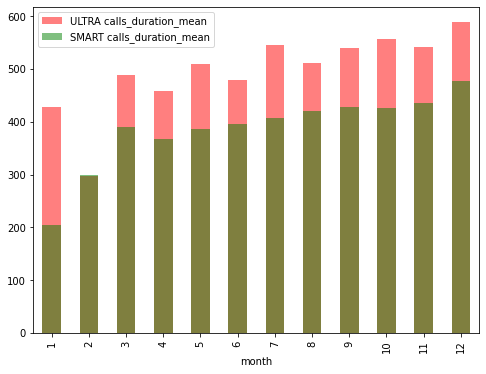

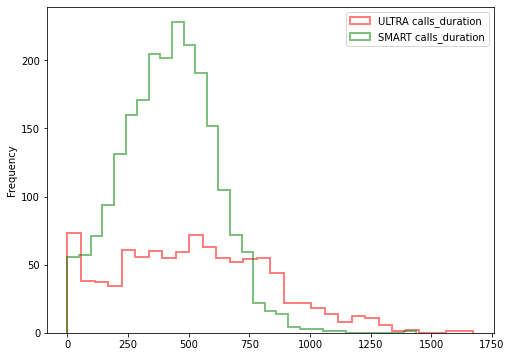

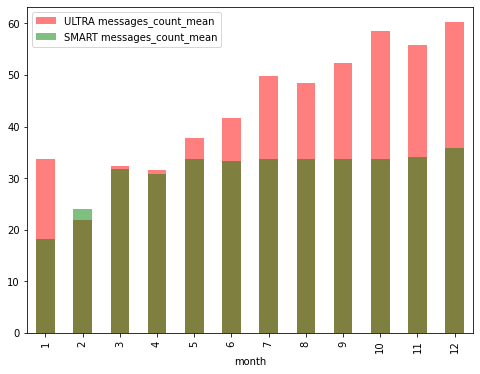

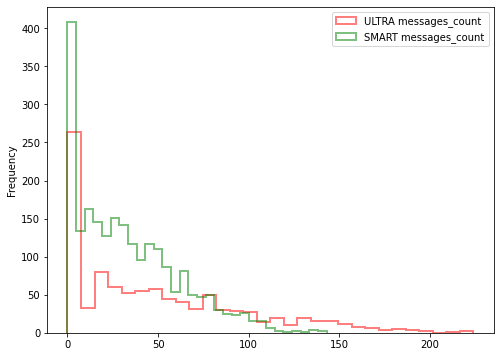

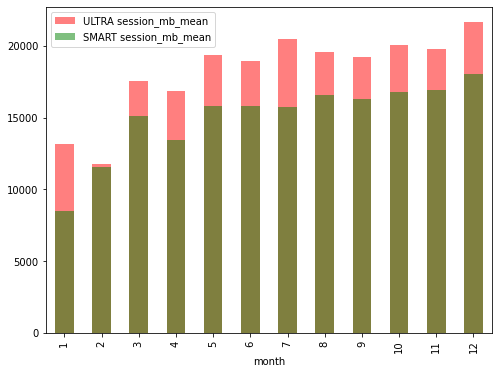

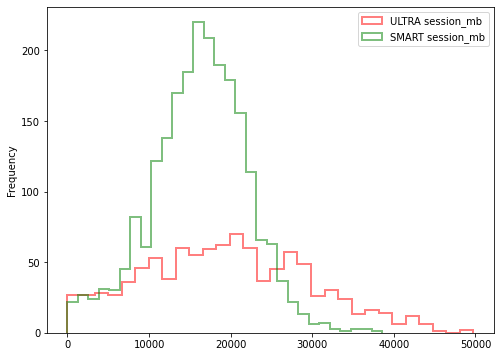

In [31]:
bar_show(pvt_ultra, pvt_smart, 'calls_duration_mean')
hist_show(df_ultra, df_smart, 'calls_duration')
bar_show(pvt_ultra, pvt_smart, 'messages_count_mean')
hist_show(df_ultra, df_smart, 'messages_count')
bar_show(pvt_ultra, pvt_smart, 'session_mb_mean')
hist_show(df_ultra, df_smart, 'session_mb')

pvt_stats = df.pivot_table(index='tariff', values=['calls_duration','messages_count','session_mb'], aggfunc=['min','max','mean', 'median', 'std', 'var'])
pvt_stats

### Выводы

- Подсчитано для каждого тарифа среднее, дисперсия и стандартное отклонение для минут разговора, количества сообщений и объёма интернет-трафика.  
- Построены barplot и hist для всех рассчитанных параметров по тарифам.   
- По минутам разговора и объему трафика картина аналогичная: в среднем больше разговаривают и пользуются интернетом абоненты тарифа ultra, данна картина наблюдается во все месяцы кроме февраля. Дисперсия и стандартное отклонение для данного тарифа также выше.
- По количеству сообщений: в среднем больше сообщений у абонентов тарифа ultra, данна картина наблюдается во все месяцы кроме февраля, марта и апреля. В данные месяцы количество сообщений по тарифам практически совпадает. Дисперсия и стандартное отклонение для данного тарифа также выше.

## Проверка гипотез

Данные проанализированы в предыдущем разделе, но компании Мегалайн наверняка интересен вопрос сравнения выручки по данным тарифам.
Сформулируем и проверим гипотезы.

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

**H0:** Средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт»  
**H1:** Средняя выручка пользователей тарифа «Ультра» не равна средней выручке пользователей тарифа «Смарт»  
**Пороговое значене статистической значимости** alpha = 0.05  
Поскольку выборки по тарифам независимые (пользователи тарифов разные) для расчета p-value используем функцию st.ttest_ind  

Для начала, построим график средней выручки по месяцам, чтобы лучше ориентироваться в данных

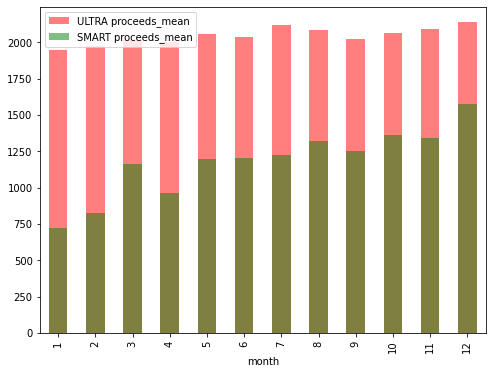

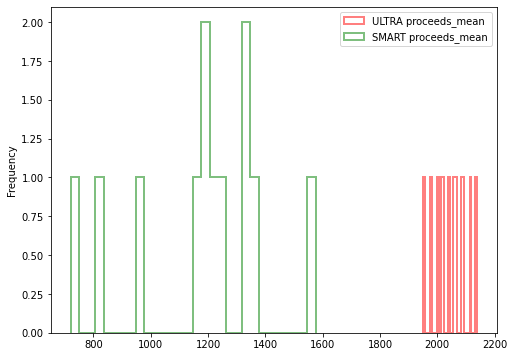

In [32]:
pvt_ultra = df_ultra.pivot_table(index='month', values=['proceeds'], aggfunc=['mean'])
pvt_ultra.columns=['proceeds_mean']
pvt_smart = df_smart.pivot_table(index='month', values=['proceeds'], aggfunc=['mean'])
pvt_smart.columns=['proceeds_mean']
bar_show(pvt_ultra, pvt_smart, 'proceeds_mean')
hist_show(pvt_ultra, pvt_smart, 'proceeds_mean')

Как видно из графика, средняя выручка пользователей тарифа ультра стабильна по месяцам и незначительно превышает абонентскую плату.  
Средняя выручка тарифа смарт растет от месяца к месяцу и к концу года значительно превышает абонентскую плату (почти в 3 раза). Таким образом можно предположить, что гипотеза H0 скорее всего будет отвергнута

In [33]:
results = st.ttest_ind(df_smart['proceeds'], df_ultra['proceeds'], equal_var=False)
print('p-value:', results.pvalue)

p-value: 1.927011394420941e-250


p-value около 0, поэтому отвергаем H0, склоняемся к H1: средняя выручка по тарифам различается

### Средняя выручка пользователей из Москвы отличается от средней выручки пользователей из других регионов

**H0:** Средняя выручка пользователей из Москвы равна средней выручки пользователей из других регионов  
**H1:** Средняя выручка пользователей из Москвы не равно средней выручке пользователей из других регионов  
**Пороговое значене статистической значимости** alpha = 0.05  
Поскольку выборки по разным регионам независимые (пользователи разные) для расчета p-value используем функцию st.ttest_ind  

In [34]:
results = st.ttest_ind(df[df['city'] == 'Москва']['proceeds'], df[df['city'] != 'Москва']['proceeds'], equal_var=False)
print('p-value:', results.pvalue)

p-value: 0.5216952110000278


p-value значительно превышает пороговое значение, поэтому выборки из генеральной совокупности не противоречат гипотезе H0. Соответственно считаем, что Средняя выручка пользователей из Москвы равна средней выручки пользователей из других регионов

### Выводы
Сформулированы и проверены гипотезы по средней выручке в зависимости от тарифа и региона (Москва и остальные). Получили результат - средняя выручка отличается по тарифам, средняя выручка для Москвы и остальных регионов не отличается

## Общий вывод по проекту

При выполнении проекта:
- загружены данные из csv файлов  
- проведена подготовка данных  
- приведены в соответствие типы колонок  
- удалены ненужные столбцы  
- сформирована общая таблица со сводными данными по услугам по месяцам  

На этапе анализа данных:
- С группировкой по месяцам подсчитано для каждого тарифа среднее, дисперсия и стандартное отклонение для минут разговора, количества сообщений и объёма интернет-трафика.  
- Построены barplot и hist для всех рассчитанных параметров по тарифам.   
- По минутам разговора и объему трафика картина аналогичная: в среднем больше разговаривают и пользуются интернетом абоненты тарифа ultra, данна картина наблюдается во все месяцы кроме февраля. Дисперсия и стандартное отклонение для данного тарифа также выше.
- По количеству сообщений: в среднем больше сообщений у абонентов тарифа ultra, данна картина наблюдается во все месяцы кроме февраля, марта и апреля. В данные месяцы количество сообщений по тарифам практически совпадает. Дисперсия и стандартное отклонение для данного тарифа также выше.

Проверены гипотезы относительно средней выручки, получен следующий результат:  
- Средняя выручка по тарифам различается, по тарифу ультра среднюю выручка выше  
- Средняя выручка пользователей из Москвы не отличается от средней выручки пользователей из других регионов 

В целом, средняя выручка пользователей тарифа ультра стабильна по месяцам и незначительно превышает абонентскую плату.  
Средняя выручка тарифа смарт растет от месяца к месяцу и к концу года значительно превышает абонентскую плату (почти в 3 раза), что связано сем, что пользователи тарифа смарт значительно превышают объем услуг, включенных в абонентскую плату.